In [1]:
import networkx as nx
import community as community_louvain
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import locale
import time

### Création du graphe à partir du fichier `edgelist`

In [2]:
G = nx.read_edgelist("youtube.graph.edgelist", nodetype=int)

In [3]:
N = G.number_of_nodes()
m = G.number_of_edges()
nb_composantes = nx.number_connected_components(G)

In [4]:
print(f"nombre de nœuds : {N}")
print(f"nombre d’arêtes : {m}")
print(f"nombre de composantes connexes : {nb_composantes}")
print(f"voisins du nœud 1 : {list(G.neighbors(11))}")

nombre de nœuds : 22754
nombre d’arêtes : 65601
nombre de composantes connexes : 1
voisins du nœud 1 : [165, 349, 718, 727, 743, 905, 908, 1042, 1073, 1119, 3491, 3493, 3511, 3517, 3518, 3519, 3533, 3535, 3540, 3542, 3546, 3548, 3558, 3559, 3562, 5109, 13568, 655575, 663545, 665658, 665659, 1085697]


### Budget idéal et couverture idéale

In [5]:
def ideal_budget_and_coverage(N, C_0=200):
    return C_0*N, 1

In [6]:
C_0 = 200
ideal_budget, ideal_coverage = ideal_budget_and_coverage(N, C_0)
print(f"budget idéal = {ideal_budget:,.2f} CAD et couverture idéale = {ideal_coverage:.0%}")

budget idéal = 4,550,800.00 CAD et couverture idéale = 100%


### Détection des communautés à l’aide de l’algorithme de Louvain.

In [7]:
def get_communities(G, algo="louvain"):
    communities = {}
    if algo=="louvain":
        partition = community_louvain.best_partition(G)
        for node, comm in partition.items():
            communities.setdefault(comm, []).append(node)
    else:
        lpa_communities = nx.algorithms.community.label_propagation_communities(G)
        lpa_result = [list(c) for c in lpa_communities]
        for i, comm in enumerate(lpa_communities):
            communities[i] = list(comm)   
    return communities

In [8]:
time_lpa = time.time()
communities_lpa = get_communities(G, algo="lpa")
time_lpa = time.time() - time_lpa
print("nombre total de communautés détectées :", len(communities_lpa))

nombre total de communautés détectées : 1319


In [9]:
time_louvain = time.time()
communities_louvain = get_communities(G, algo="louvain")
time_louvain = time.time() - time_louvain
print("nombre total de communautés détectées :", len(communities_louvain))

nombre total de communautés détectées : 32


### Détermination d’un·e influenceur·euse par communauté, choisi·e selon la centralité de proximité

In [10]:
def get_community_and_profiles(G, communities, influence="closeness"):
    com_and_profiles = {}
    for comm_id, nodes in communities.items():
        community = G.subgraph(nodes)
        if influence=="closeness":
            closeness = nx.closeness_centrality(community)
            influencer = max(closeness, key=closeness.get)
        elif influence=="degree":
            degree = nx.degree_centrality(community)
            influencer = max(degree, key=degree.get)
        elif influence=="betweenness":
            betweenness = nx.betweenness_centrality(community)
            influencer = max(betweenness, key=betweenness.get)
        else:
            influencer = np.random.choice(list(nodes))
        profile = {"community":community, "influencer": influencer}
        com_and_profiles[comm_id]=profile
    return com_and_profiles 

In [11]:
timer = time.time()
com_and_profiles_louvain = get_community_and_profiles(G, communities_louvain, influence="closeness")
time_louvain += time.time() - timer

In [12]:
timer = time.time()
com_and_profiles_lpa = get_community_and_profiles(G, communities_lpa, influence="random")
time_lpa += time.time() - timer

###  Simulation du budget et de la couverture obtenue par propagation de l’influence

In [13]:
def get_budget_coverage_per_community(com_and_profile, N, eta = 2, C_1=20, C_2=1000):
    community = com_and_profile['community']
    influencer = com_and_profile['influencer']
    counter = 1
    temps_propagation = 0
    for node in community.nodes():
        if node != influencer:
            prob = np.random.uniform(0.8, 1)
            choice = np.random.choice([0, 1], p=[1-prob, prob])
            if choice == 1:
                try:
                    distance = nx.shortest_path_length(community, source=influencer, target=node)
                    counter +=1
                    temps_propagation += distance
                except Exception as e:
                    continue
                
    budget = C_2 + (counter-1)*C_1
    temps_propagation *= eta
    coverage = counter/N
    return budget, coverage, temps_propagation

In [14]:
def get_budget_and_coverage(com_and_profiles, eta=2, C_1=20, C_2=1000):
    total_budget, total_coverage, total_temps_propagation = 0, 0, 0
    for comm_id in com_and_profiles:
        com_and_profile = com_and_profiles[comm_id]
        budget, coverage, temps_propagation = get_budget_coverage_per_community(com_and_profile, N, eta, C_1, C_2)
        total_budget +=budget
        total_coverage +=coverage
        total_temps_propagation +=temps_propagation
    return total_budget, total_coverage, total_temps_propagation

In [15]:
eta, C_1, C_2 =2, 20, 1000

In [16]:
timer = time.time()
sim_budget_louvain, sim_coverage_louvain, sim_temps_propagation_louvain = get_budget_and_coverage(com_and_profiles_louvain, eta, C_1, C_2)
time_louvain += time.time() - timer
print(f"budget simulé = {sim_budget_louvain:,.2f} CAD, couverture simulée = {sim_coverage_louvain:.0%} et temps de propagation = {sim_temps_propagation_louvain:,.2f} sec ")

budget simulé = 441,960.00 CAD, couverture simulée = 90% et temps de propagation = 95,310.00 sec 


In [17]:
timer = time.time()
sim_budget_lpa, sim_coverage_lpa, sim_temps_propagation_lpa = get_budget_and_coverage(com_and_profiles_lpa, eta, C_1, C_2)
time_lpa += time.time() - timer
print(f"budget simulé = {sim_budget_lpa:,.2f} CAD, couverture simulée = {sim_coverage_lpa:.0%} et temps de propagation = {sim_temps_propagation_lpa:,.2f} sec ")

budget simulé = 1,703,400.00 CAD, couverture simulée = 90% et temps de propagation = 154,334.00 sec 


### Comparez les différents résultats obtenus

Comparez les différents résultats obtenus selon la méthode de détection des communautés et l’approche de détermination des nœuds influenceurs, 
      en termes de budget simulé, de couverture simulée, de temps total de propagation et de temps d’exécution. Proposez des visualisations pertinentes afin de faciliter la comparaison des résultats, notamment en termes de couverture perdue et de montant d’argent épargné par approche.

In [18]:

louvain = {   
    'Méthode' : 'louvain',
    'Influence':'closeness',
    'Budget simulé': sim_budget_louvain,
    "Couverture simulée": sim_coverage_louvain,
    "Propagation": sim_temps_propagation_louvain,
    "Execution" : time_louvain
}
lpa = {
    'Méthode' : 'lpa',
    'Influence':'random',
    'Budget simulé': sim_budget_lpa,
    "Couverture simulée": sim_coverage_lpa,
    "Propagation": sim_temps_propagation_lpa,
    "Execution" : time_lpa
}

for method in ([louvain,lpa]):
    method["Couverture perdue"] = ideal_coverage - method["Couverture simulée"]
    method["Argent économisé"] = ideal_budget - method["Budget simulé"]

results = pd.DataFrame([louvain,lpa])



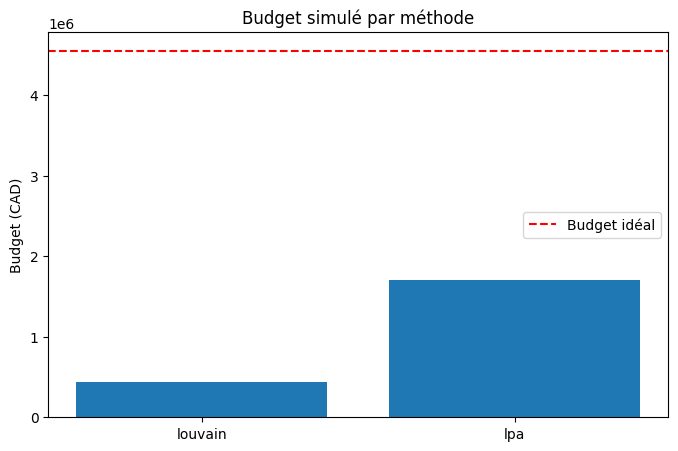

In [19]:
plt.figure(figsize=(8,5))
plt.bar(results["Méthode"], results["Budget simulé"])
plt.axhline(ideal_budget, color='red', linestyle='--', label="Budget idéal")
plt.ylabel("Budget (CAD)")
plt.title("Budget simulé par méthode")
plt.legend()
plt.show()

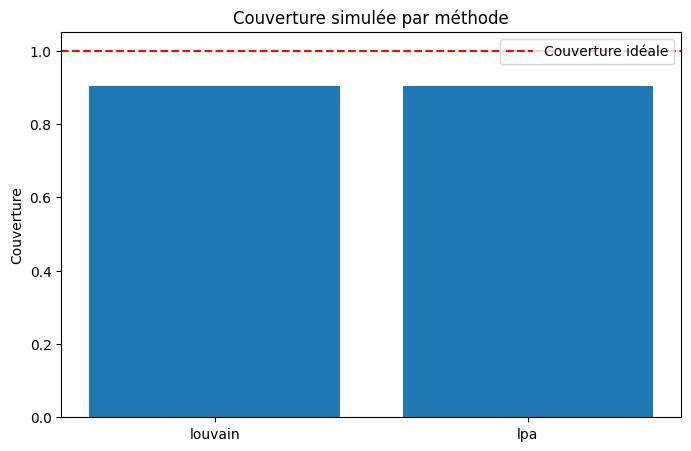

In [20]:
plt.figure(figsize=(8,5))
plt.bar(results["Méthode"], results["Couverture simulée"])
plt.axhline(ideal_coverage, color='red', linestyle='--', label="Couverture idéale")
plt.ylabel("Couverture")
plt.title("Couverture simulée par méthode")
plt.legend()
plt.show()

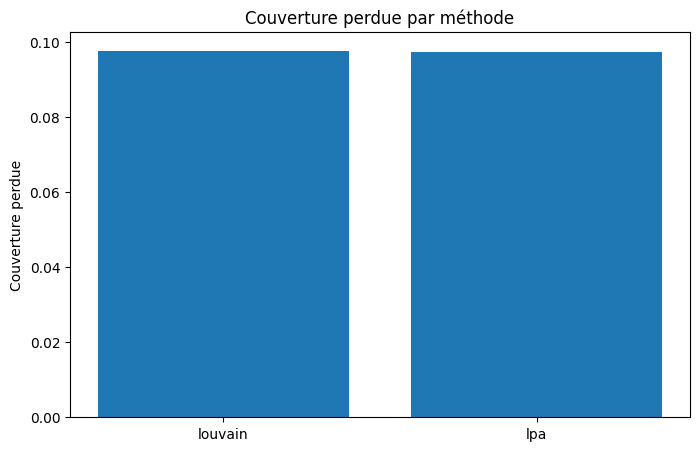

In [21]:
plt.figure(figsize=(8,5))
plt.bar(results["Méthode"], results["Couverture perdue"], )
plt.ylabel("Couverture perdue")
plt.title("Couverture perdue par méthode")
plt.show()

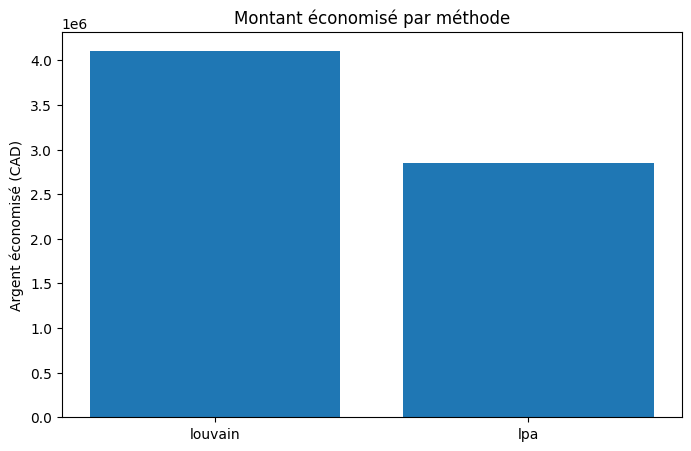

In [22]:
plt.figure(figsize=(8,5))
plt.bar(results["Méthode"], results["Argent économisé"])
plt.ylabel("Argent économisé (CAD)")
plt.title("Montant économisé par méthode")
plt.show()

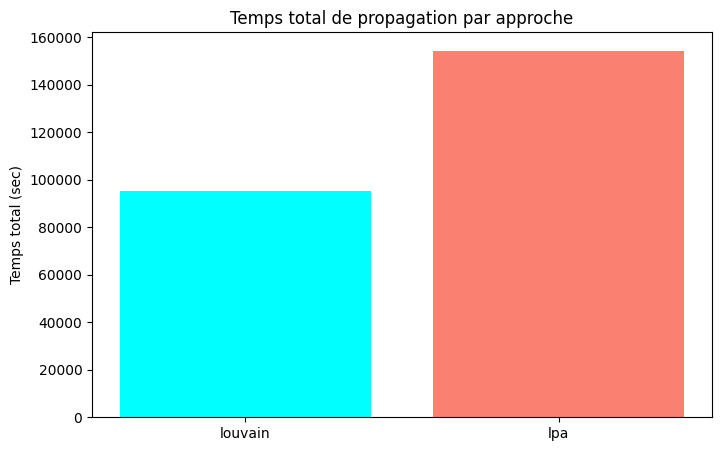

In [23]:
plt.figure(figsize=(8,5))
plt.bar(results["Méthode"], results["Propagation"], color=["cyan", "salmon"])
plt.ylabel("Temps total (sec)")
plt.title("Temps total de propagation par approche")
plt.show()

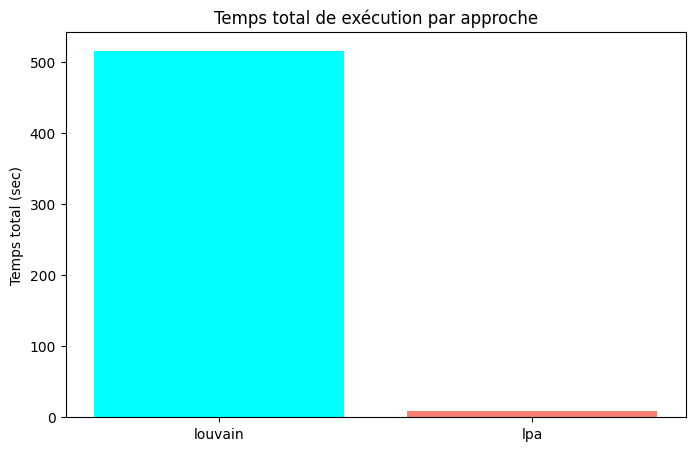

In [24]:
plt.figure(figsize=(8,5))
plt.bar(results["Méthode"], results["Execution"], color=["cyan", "salmon"])
plt.ylabel("Temps total (sec)")
plt.title("Temps total de exécution par approche")
plt.show()